In [3]:
from typing import TypedDict,Annotated,Optional
from langgraph.graph import add_messages,StateGraph,END
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json


load_dotenv()

model = ChatGroq(model="llama-3.1-8b-instant")

model.invoke("hi")


AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.012850721, 'completion_tokens_details': None, 'prompt_time': 0.002492921, 'prompt_tokens_details': None, 'queue_time': 0.058004619, 'total_time': 0.015343642}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b6d31-8e12-7761-81c6-1fdab69b53eb-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})

In [6]:
search_tool = TavilySearchResults(max_results=4)

tools = [search_tool]

memory = MemorySaver()



In [ ]:
llm_with_tools = model.bind_tools(tools=tools)




AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'xdx10mt6j', 'function': {'arguments': '{"query":"current weather in bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 288, 'total_tokens': 310, 'completion_time': 0.033157069, 'completion_tokens_details': None, 'prompt_time': 0.016425003, 'prompt_tokens_details': None, 'queue_time': 0.054892797, 'total_time': 0.049582072}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b6d34-a1b3-7c71-96cc-53510123a5b6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in bangalore'}, 'id': 'xdx10mt6j', 'type': 'tool_call'}], usage_metadata={'input_tokens': 288, 'output_tokens': 22, 'total_tokens': 310})

In [12]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router,["tool_node", END],
)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)


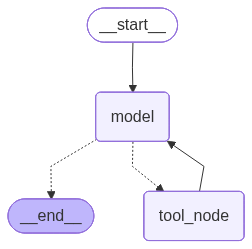

In [13]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)


In [ ]:
config = {
    "configurable":{
        "thread_id":1
    }
}

response = await graph.ainvoke({
    "messages":[HumanMessage(content="when is the next space-x launch?")]},config=config
)
response

{'messages': [HumanMessage(content='hi I am yuvi?', additional_kwargs={}, response_metadata={}, id='4eaca619-1294-46a9-ac09-80ffaea6568b'),
  AIMessage(content="I'm happy to chat with you, Yuvi! Is there something on your mind that you'd like to talk about or ask about?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 284, 'total_tokens': 313, 'completion_time': 0.05930869, 'completion_tokens_details': None, 'prompt_time': 0.019075993, 'prompt_tokens_details': None, 'queue_time': 0.050954967, 'total_time': 0.078384683}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b6d41-82b3-7002-9728-7a76557456ed-0', usage_metadata={'input_tokens': 284, 'output_tokens': 29, 'total_tokens': 313}),
  HumanMessage(content='hi I am yuvi?', additional_kwargs={}, response_metadata={}, id='9d4e6f1d-3a12-4b23-9385-

In [38]:
config = {
    "configurable":{
        "thread_id":5
    }
}

async for event in graph.astream_events(
    {"messages": [HumanMessage(content="write a 50 words essay on climate changes?")]},
    config=config,
    version="v2",
):
    if event["event"] == "on_chain_stream" and event.get("name") == "model":
        chunk = event["data"]["chunk"]
        if "messages" in chunk:
            print(chunk["messages"][-1].content, end="", flush=True)



APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `llama-3.1-8b-instant` in organization `org_01k3wyrekvfn3sc70050vygff3` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Requested 6067, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}